In [108]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [180]:
import os
#data_file_path = os.path.join(os.path.dirname(__file__), "YX.csv")
data_file_path = os.path.join(os.getcwd(), "Data\YX.csv")
#data_file_path = os.path.join(os.getcwd(), "Compustat.csv")

In [181]:
import pandas as pd
RData = pd.read_csv(data_file_path)
finalData=RData
finalData


# finalData = dataset.map(..., num_parallel_calls=10)
# finalData = dataset.prefetch(buffer_size)

,returns,MktCap,gvkey,fdateq,datadate,datacqtr,curcdq,accdq,acoq,acoxq,...,city,fyrc,ggroup,gind,gsector,gsubind,idbflag,loc,naics,sic
0,-3.470772,1.039912e+09,1166,20100503,20100806,2010Q1,EUR,67.0350,47.3020,47.3020,...,Almere,12,4530,453010,45,45301010,B,NLD,333242,3559
1,51.662612,1.003819e+09,1166,20100907,20101105,2010Q2,EUR,113.1330,55.8040,55.8040,...,Almere,12,4530,453010,45,45301010,B,NLD,333242,3559
2,4.705882,1.522417e+09,1166,20101105,20110204,2010Q3,EUR,87.2820,70.5220,70.5220,...,Almere,12,4530,453010,45,45301010,B,NLD,333242,3559
3,-25.597342,1.594061e+09,1166,20110330,20110506,2010Q4,EUR,63.8670,67.9700,67.9700,...,Almere,12,4530,453010,45,45301010,B,NLD,333242,3559
4,23.676880,1.169086e+09,1166,20110811,20111104,2011Q2,EUR,284.1220,82.1470,82.1470,...,Almere,12,4530,453010,45,45301010,B,NLD,333242,3559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57142,-15.362035,3.179257e+09,352058,20220317,20220506,2020Q3,TRY,80.4916,77.7721,73.4729,...,Istanbul,12,1510,151040,15,15104050,I,TUR,331210,3317
57143,18.970238,4.901884e+09,352242,20220218,20220506,2020Q4,CNY,24.4102,22.6773,8.7507,...,Dalian,12,1510,151010,15,15101050,I,CHN,325180,2810
57144,0.000000,2.134020e+10,352246,20220302,20220506,2021Q2,CNY,403.2107,40.6519,40.6519,...,Shenzhen,12,2010,201060,20,20106020,I,CHN,333249,3559
57145,0.000000,2.536682e+10,352430,20220302,20220506,2020Q3,TWD,122.9320,155.1190,93.0920,...,Taoyuan,12,2010,201010,20,20101010,I,TWN,488190,4581


In [111]:
# import dask.dataframe
# finalData = dask.dataframe.read_csv(data_file_path)
# finalData
finalData.dtypes


testDF = pd.DataFrame({
    "A": [1, 2],
    "B": [6, 7]
}
)


In [182]:
# trainY = finalData["returns"][0:20].compute()
# trainY
# trainX = finalData.loc[:, finalData.columns != "returns"]
# trainX

import numpy as np


factorCols = ["gvkey", "datacqtr", "sic", "naics", "loc", "idbflag",
              "gsubind", "ggroup", "gind", "gsector",
              "fic", "city", "fyrc",
              "curcdq", "exchg", "fdateq", "datadate"]

finalData[factorCols] = finalData[factorCols].astype("str")


nonNumCols = ["returns", "MktCap", "fdateq", "datacqtr", "datadate"] + factorCols
numCols     = finalData.columns.difference(nonNumCols)


finalData["fdateq"] = pd.to_datetime(finalData["fdateq"], format = "%Y%m%d")
finalData["datadate"] = pd.to_datetime(finalData["datadate"], format = "%Y%m%d")
#finalData["fdateq"] = pd.to_datetime(finalData["datacqtr"], format = "%Y%q") #check quarter format


#Currently not grouped by quarter
finalData = finalData.sort_values(by=['datacqtr', "fdateq"])

trainSize = round(len(finalData.index)*0.4)
validationSize = round(len(finalData.index)*0.7)




Y = finalData["returns"]
Y = np.asarray(Y).astype('float32')
yTrain, yVal, yTest = Y[:trainSize], Y[trainSize:validationSize], Y[validationSize:]

X = finalData.loc[:, finalData.columns != "returns"]



X = X.select_dtypes(include=[np.number])
#X = X.dropna()





In [183]:
#X.dtypes

#finalData.info(verbose=True)
finalData[numCols].info(verbose=True)
#finalData.dtypes
#print(finalData.dtypes)
#finalData.columns


<class 'pandas.core.frame.DataFrame'>
Int64Index: 57147 entries, 5086 to 40127
Data columns (total 85 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   accdq     57147 non-null  float64
 1   acoq      57147 non-null  float64
 2   acoxq     57147 non-null  float64
 3   actq      57147 non-null  float64
 4   ancq      57147 non-null  float64
 5   aoq       57147 non-null  float64
 6   apq       57147 non-null  float64
 7   atq       57147 non-null  float64
 8   capsq     57147 non-null  float64
 9   capxy     57147 non-null  float64
 10  ceqq      57147 non-null  float64
 11  chechy    57147 non-null  float64
 12  cheq      57147 non-null  float64
 13  cogsq     57147 non-null  float64
 14  cogsy     57147 non-null  float64
 15  cstkq     57147 non-null  float64
 16  dfxaq     57147 non-null  float64
 17  dfxay     57147 non-null  float64
 18  dlcq      57147 non-null  float64
 19  dlttq     57147 non-null  float64
 20  dpcy      57147 non-null 

In [184]:
#Ratio data
#xRatioData = finalData.apply(lambda x: x/finalData["revtq"])
xRatioData = finalData

xRatioData[numCols] = finalData[numCols].div(finalData["MktCap"].values, axis=0)
#xRatioData = X.div(finalData["MktCap"].values, axis=0)
#xRatioData = xRatioData.loc[:, xRatioData.columns != "MktCap"]


#xRatioData = xRatioData.dropna()
xRatioData


,returns,MktCap,gvkey,fdateq,datadate,datacqtr,curcdq,accdq,acoq,acoxq,...,city,fyrc,ggroup,gind,gsector,gsubind,idbflag,loc,naics,sic
5086,6.666667,2.256929e+09,201336,2009-11-30,2010-02-05,2009Q3,ARS,1.588880e-07,5.306991e-08,4.108016e-08,...,Buenos Aires,6,3020,302020,30,30202010,B,ARG,999977,9997
3967,8.908046,6.761640e+09,200144,2009-12-19,2010-02-05,2009Q3,ARS,2.110858e-08,3.906671e-09,2.319733e-09,...,Buenos Aires,6,1510,151040,15,15104010,I,ARG,331313,3334
33558,-7.210031,3.416427e+08,278800,2010-01-23,2010-02-05,2009Q3,ARS,8.138941e-08,1.022846e-07,1.012171e-07,...,Buenos Aires,12,3020,302020,30,30202030,I,ARG,3114,2030
11596,26.707541,1.183917e+09,210918,2010-03-19,2010-05-06,2009Q3,EUR,2.973182e-08,2.390371e-08,1.317660e-08,...,Paris,6,3020,302020,30,30202010,I,FRA,111422,100
36083,-16.798942,1.001041e+08,282729,2010-03-21,2010-05-06,2009Q3,EUR,3.579872e-07,8.519129e-08,8.519129e-08,...,Decines-Charpieu,6,5020,502020,50,50202010,I,FRA,711211,7941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39619,0.000000,1.462751e+08,288572,2022-06-08,2022-08-05,2022Q1,PLN,1.121299e-06,1.310613e-07,1.310613e-07,...,Warsaw,12,2010,201030,20,20103010,I,POL,237,1600
8336,0.000000,2.412256e+12,204867,2022-06-11,2022-08-05,2022Q1,INR,5.173704e-08,2.753729e-08,2.097124e-08,...,Bengaluru,3,4510,451020,45,45102010,B,IND,541512,7373
46678,0.000000,1.415597e+09,297105,2022-06-13,2022-08-05,2022Q1,TWD,8.187357e-08,5.821289e-08,9.711096e-09,...,New Taipei City,12,3510,351010,35,35101020,I,TWN,334510,3845
50155,0.000000,1.616189e+09,313975,2022-06-13,2022-08-05,2022Q1,PLN,4.981782e-08,8.811205e-07,8.811205e-07,...,Konin,12,5510,551010,55,55101010,I,POL,2211,4911


In [188]:
#Winsorised data
import scipy


# XArray = np.asarray(xRatioData).astype('float32')
# # numberOfVariables = XArray.shape[1]

# xWinData = scipy.stats.mstats.winsorize(XArray, limits = (0.01, 0.01))
# #yWinData = scipy.stats.mstats.winsorize(XArray, limits = (0.01, 0.01))


xWinData=xRatioData

xWinData[numCols] = xRatioData[numCols].apply(lambda x: scipy.stats.mstats.winsorize(x, limits = (0.01, 0.01)))


In [216]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler(feature_range=(0,1))
#scaler = StandardScaler()

# scaled_X = scaler.fit_transform(XArray)
# #scaled_X = np.apply_along_axis(func1d=scaler.fit_transform, axis=1, arr=X) #Why over rows??? prob axis=0 instead

# xTrain, xVal, xTest = scaled_X[:trainSize,:], scaled_X[trainSize:validationSize,:], scaled_X[validationSize:, :]

# scaled_winX = scaler.fit_transform(xWinData)
# xWinTrain, xWinVal, xWinTest = scaled_winX[:trainSize,:], scaled_winX[trainSize:validationSize,:], scaled_winX[validationSize:, :]


xScaledData=xWinData
#xScaledData[numCols] = xScaledData[numCols].apply(lambda x: scaler.fit_transform(x))
xScaledData[numCols] = scaler.fit_transform(xScaledData[numCols])





#scaled_X = scaled_X.apply(lambda x : x.reshape(-1, 1))
# droppedCols = ["ajexdi", "prccd", "trfd"]
# trainX.drop(droppedCols, axis=1, inplace=True)
# trainX['gvkey'] = trainX['gvkey'].astype(object)
# trainX['gvkey'] = trainX['gvkey'].astype(object)

#trainX.dtypes

In [218]:
ScaledWinsRatioPath = os.path.join(os.getcwd(), "Data\ScaledWinsRatioData.csv")


# XOutputDF = pd.DataFrame(scaled_winX)
# YOutputDF = pd.DataFrame(Y)

# NNReadyDataWithLabels = XOutputDF.append(finalData["fdateq"], finalData["datadate"], finalData["datacqtr"], YOutputDF)

#np.savetxt(ScaledWinsRatioPath, xScaledData, delimiter=",")
pd.DataFrame(xScaledData).to_csv(ScaledWinsRatioPath, index=False)


In [ ]:
#Currently not grouped by quarter
xScaledData = xScaledData.sort_values(by=['datacqtr', "fdateq"])
trainSize = round(len(xScaledData.index)*0.4)
validationSize = round(len(xScaledData.index)*0.7)


#Currently not grouped by quarter
trainSize = round(len(xScaledData.columns)*0.4)
validationSize = round(len(xScaledData.columns)*0.7)



Y = xScaledData["returns"]
Y = np.asarray(Y).astype('float32')
yTrain, yVal, yTest = Y[:trainSize], Y[trainSize:validationSize], Y[validationSize:]

X = xScaledData.drop(["returns", "MktCap"], axis=1)
X = X.select_dtypes(include=[np.number])
xWinTrain, xWinVal, xWinTest = X[:trainSize, :], X[trainSize:validationSize, :], X[validationSize:, :]

In [119]:

# groupedY = Y.groupby(["state", "gender"])["last_name"].count()
# yTrain, yVal, yTest = Y[:trainSize], Y[trainSize:validationSize], Y[validationSize:]



# groupedX = scaled_X.groupby(["state", "gender"])["last_name"].count()
# xTrain, xVal, xTest = scaled_X[:trainSize,:], scaled_X[trainSize:validationSize,:], scaled_X[validationSize:, :]




In [120]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print("Num GPUs Available: ", len(physical_devices))
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [121]:
# model = Sequential([
#     Dense(units=16,  activation='relu'), #input_shape=(, 10, numberOfVariables),
#     Dense(units=32, activation='relu'),
#     Dense(units=1)
# ])


In [122]:
# model = tf.keras.Sequential()

# model.add(Dense(units=10,  activation='relu'))
# model.add(tf.keras.layers.Dropout(.5))
# model.add(Dense(units=10, activation='relu'))
# model.add(Dense(units=1))

In [123]:
# model.compile(optimizer="sgd",  # Adam(learning_rate=0.0001),
#               loss="MeanSquaredError", #'tf.keras.losses.MeanSquaredError()',
#               metrics=['accuracy'])

In [124]:
# model.fit(x=xTrain, y=yTrain,
#           batch_size=10, epochs=30, verbose=2)


In [125]:
# loss_and_metrics = model.evaluate(xVal, yVal, batch_size=128)

# model.predict(xVal, batch_size=128)

In [195]:
def NNfunction(modelType, layers, hidUnits, actvFunc, dropout, L1, L2):
    
    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=3, verbose=1, restore_best_weights=True) #Can this be taken out from the loop? => Less computing

    #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
    #callback = tf.keras.callbacks.BackupAndRestore(backup_dir="/tmp/backup")


    model = tf.keras.Sequential()

    if modelType == "LSTM":
        model.add(tf.keras.layers.LSTM(units=hidUnits, input_shape=(2,)))
    elif modelType == "GRU":
        model.add(tf.keras.layers.GRU(units=hidUnits))
    elif modelType == "SimpleRNN":
        # keras.layers.SimpleRNN(1, input_shape=[None, 1])
        model.add(tf.keras.layers.SimpleRNN(units=hidUnits))
    elif modelType == "Linear":
        model.add(Dense(units=1,
                        kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2)))   #insert lasso and ridge here
    else:
        try:
            for n in range(0, layers):
                model.add(Dense(units=hidUnits,
                                activation=actvFunc,
                                kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2)))
                model.add(tf.keras.layers.Dropout(dropout))
                # scaler.fit_transform
                # tf.keras.layers.BatchNormalization(
        except:
            model.add(Dense(units=hidUnits, activation=actvFunc,
                            kernel_regularizer=tf.keras.regularizers.L1L2(l1=L1, l2=L2)))
            model.add(tf.keras.layers.Dropout(dropout))

            
        model.add(Dense(units=1))



    model.compile(optimizer="RMSprop",  # Adam(learning_rate=0.0001) #RMSprop #sgd
                  loss="MeanSquaredError",  # 'tf.keras.losses.MeanSquaredError()'  #Huber   #MeanAbsoluteError
                  metrics=["MeanAbsoluteError"]) #accuracy




    # model.fit(x=xTrain, y=yTrain,
    #           batch_size=16, epochs=epo, verbose=2)

    #loss_and_metrics = model.evaluate(xVal, yVal, batch_size=128)
    


    history = model.fit(x=xWinTrain, y=yTrain,
              batch_size=32, epochs=100,
              callbacks= [callback], verbose=2, validation_data = (xWinVal, yVal))

    loss_and_metrics = model.evaluate(xWinVal, yVal, batch_size=32)
    
    epochs_EarlyStopping = len(history.history['loss'])
    #history.history[]




    # quarters = len(yVal)
    # CV = []
    # for q in range(0, quarters):

    #     model.fit(x=xTrain, y=yTrain,
    #           batch_size=16, epochs=epo, verbose=2)

    #     validationError = model.evaluate(xVal, yVal, batch_size=128)
    #     CV = [CV, validationError]


    
    
    try:
        loss_and_metrics = [x for x in loss_and_metrics]
    except:     
        print(loss_and_metrics)

    return loss_and_metrics, model, epochs_EarlyStopping

    #model.predict(xVal, batch_size=128)

    





In [154]:
#Hyper-Parameters
NNModelType = {"Forward"} #, "LSTM", "GRU"}
hiddenLayers = {2, 3, 4, 5}
hiddenUnits = {2, 3, 4, 5, 10}
activationFunc = {"relu", "sigmoid", "tanh"} #etc. https://keras.io/api/layers/activations/
dropOut = {0.5, 0.2, 0}
#epochs = [100] #Just choose best model. => Run for 100 epochs, but if 20th epoch is the best, choose it, i.e. early stopping
#inputSize = numberOfVariables #ncol(trainXPools[[1]])
#other parameters: loss func, node structure, location of the regularization function
batchSize = {8, 16, 32, 64}
optim = {"RMSprop", "Adam", "sgd"}


none = {"NA"}

L1L2Grid = 10**np.linspace(start=3, stop=-5, num=3) #3 and -10
L1L2Grid = set(np.append(L1L2Grid, 0))


NNParams = {"Model type": NNModelType,  # , "LSTM", "GRU"},
            "Hidden layers": hiddenLayers,
            "Hidden units": hiddenUnits,
            "Activation function": activationFunc,
            "Dropout": dropOut,
            "L1": L1L2Grid,
            "L2": L1L2Grid
            }

LinearParams = {"Model type": {"Linear"},
               "Hidden layers": none,
               "Hidden units": none,
               "Activation function": none,
               "Dropout": none,
               "L1": L1L2Grid,
               "L2": L1L2Grid
               }



import itertools
import pandas as pd
NNGrid = pd.DataFrame(itertools.product(
    *NNParams.values()), columns=NNParams.keys())

linearGrid = pd.DataFrame(itertools.product(
    *LinearParams.values()), columns=LinearParams.keys())


#Random grid search
#import random
#random.seed(2302)
randomNNGrid = NNGrid.sample(n=160)

HPGrid = pd.concat([linearGrid, randomNNGrid])


# hyperParams = np.concatenate((LinearParams, NNParams, RNNParams))
#hyperParams = np.concatenate(grid, LinearParams)







In [155]:
MSEMatrix = pd.DataFrame()
pd.options.mode.chained_assignment = None


#validationSize = 2 #length(validXPools)
#HPsize = len(hyperParams.index)
HPsize = np.shape(HPGrid)[0]
#HPsize = 2   #176 models took 40 min

for n in range(0, HPsize):
  print("\n")
  print("Model ", str(n+1), " out of ", str(HPsize))

  HP = HPGrid.iloc[n]
  CV = NNfunction(*HP)

  #a = pd.DataFrame([CV])
  newMSE = HPGrid.iloc[[n]]

  MSE = CV[0][0]
  MAE = CV[0][1]
  Epochs = CV[2]
  ModelPointer = CV[1]

  # newMSE['MSE'] = MSE
  # newMSE['MAE'] = MAE

  newMSE.loc[:,"Epochs"] = Epochs
  newMSE.loc[:,"MSE"] = MSE
  newMSE.loc[:,"MAE"] = MAE
  newMSE.loc[:,"ModelPointer"] = ModelPointer

  MSEMatrix = pd.concat((MSEMatrix, newMSE), axis=0)
  
  # newMSE = a.join(b)
  # newMSE2 = pd.concat([b, a])
  #newMSE = pd.concat([b, a], axis=1, ignore_index=True, sort=False)
  #newMSE =  pd.concat(HPGrid.iloc[[n]], CV)
  #newMSE = np.concatenate((HP, CV))
  #MSEMatrix = np.concatenate((MSEMatrix, newMSE))
  #MSEMatrix = pd.concat(MSEMatrix, newMSE)
  #MSEMatrix = pd.concat([MSEMatrix, [HP, CV]])

finalResults = MSEMatrix

#finalResults[:,-1] = apply(finalResults[,-1], MARGIN=2, FUN=as.numeric)
#finalResults = finalResults[order(finalResults[,"MSE"]),]
#finalResults <- apply(finalResults, 2, as.character)

#write.csv2(finalResults, "results3.csv", row.names = FALSE)


#pd.DataFrame.to_csv(MSEMatrix, "resultsPython.csv")


#finalResults = finalResults[order(finalResults[,"MSE"]),]

formattedMSEMatrix = finalResults.sort_values(by=["MSE"], axis = 0)
formattedMSEMatrix




Model  1  out of  176
Epoch 1/100
715/715 - 4s - loss: 3353.3440 - mean_absolute_error: 19.9508 - val_loss: 2551.5393 - val_mean_absolute_error: 21.0958 - 4s/epoch - 5ms/step
Epoch 2/100
715/715 - 2s - loss: 1912.9626 - mean_absolute_error: 19.9626 - val_loss: 2558.2654 - val_mean_absolute_error: 21.1621 - 2s/epoch - 3ms/step
Epoch 3/100
715/715 - 3s - loss: 1908.4602 - mean_absolute_error: 19.9844 - val_loss: 2551.9763 - val_mean_absolute_error: 21.2343 - 3s/epoch - 4ms/step
Epoch 4/100
Restoring model weights from the end of the best epoch: 1.
715/715 - 2s - loss: 1904.5668 - mean_absolute_error: 20.0094 - val_loss: 2557.4236 - val_mean_absolute_error: 21.3069 - 2s/epoch - 3ms/step
Epoch 4: early stopping
536/536 [==============================] - 1s 2ms/step - loss: 2551.5393 - mean_absolute_error: 21.0958


Model  2  out of  176
Epoch 1/100
715/715 - 3s - loss: 3161.2029 - mean_absolute_error: 19.9515 - val_loss: 2554.7896 - val_mean_absolute_error: 21.0957 - 3s/epoch - 5ms/step


,Model type,Hidden layers,Hidden units,Activation function,Dropout,L1,L2,Epochs,MSE,MAE,ModelPointer
5,Linear,NA,NA,NA,NA,0.00000,0.00000,10,2510.909424,21.442450,<keras.engine.sequential.Sequential object at ...
1485,Forward,4,2,sigmoid,0.2,0.00001,0.00000,6,2510.909912,21.448265,<keras.engine.sequential.Sequential object at ...
7,Linear,NA,NA,NA,NA,0.00000,0.00001,10,2510.910156,21.441525,<keras.engine.sequential.Sequential object at ...
798,Forward,3,2,relu,0.0,0.00001,0.10000,9,2510.910400,21.449505,<keras.engine.sequential.Sequential object at ...
13,Linear,NA,NA,NA,NA,0.00001,0.00000,10,2510.910645,21.447845,<keras.engine.sequential.Sequential object at ...
...,...,...,...,...,...,...,...,...,...,...,...
1345,Forward,3,10,relu,0.5,1000.00000,0.00000,7,3027.843750,21.993797,<keras.engine.sequential.Sequential object at ...
1347,Forward,3,10,relu,0.5,1000.00000,0.00001,6,3030.865234,21.850685,<keras.engine.sequential.Sequential object at ...
1363,Forward,3,10,relu,0.0,1000.00000,0.00001,5,3033.365479,21.966415,<keras.engine.sequential.Sequential object at ...
2080,Forward,4,10,relu,0.0,1000.00000,1000.00000,5,3088.315186,21.761944,<keras.engine.sequential.Sequential object at ...


In [129]:
formattedMSEMatrix = finalResults.sort_values(by=["MSE"], axis = 0)
formattedMSEMatrix

,Model type,Hidden layers,Hidden units,Activation function,Dropout,L1,L2,Epochs,MSE,MAE,ModelPointer
1270,Forward,3,5,tanh,0.0,0.00000,0.10000,17,2444.441895,21.514694,<keras.engine.sequential.Sequential object at ...
219,Forward,2,3,relu,0.0,0.10000,0.00001,17,2462.684814,21.862396,<keras.engine.sequential.Sequential object at ...
134,Forward,2,2,tanh,0.2,0.00000,0.10000,22,2465.591553,21.600172,<keras.engine.sequential.Sequential object at ...
634,Forward,2,10,relu,0.5,0.10000,0.10000,16,2474.922852,21.608356,<keras.engine.sequential.Sequential object at ...
378,Forward,2,4,relu,0.2,0.10000,0.10000,16,2474.937988,21.716270,<keras.engine.sequential.Sequential object at ...
7,Linear,NA,NA,NA,NA,0.00000,0.00001,37,2476.065674,22.052103,<keras.engine.sequential.Sequential object at ...
13,Linear,NA,NA,NA,NA,0.00001,0.00000,35,2476.765137,22.042515,<keras.engine.sequential.Sequential object at ...
15,Linear,NA,NA,NA,NA,0.00001,0.00001,28,2478.234131,21.954178,<keras.engine.sequential.Sequential object at ...
5,Linear,NA,NA,NA,NA,0.00000,0.00000,28,2478.296875,21.960674,<keras.engine.sequential.Sequential object at ...
93,Forward,2,2,relu,0.2,0.00001,0.00000,40,2479.323975,21.899988,<keras.engine.sequential.Sequential object at ...


In [156]:
#MSEMatrix

finalResults = finalResults.reset_index()
index = finalResults['MSE'].idxmin()
#bestParams = finalResults.iloc[index][:-3]
#bestModel = finalResults(*bestParams)[1]
#bestParams = finalResults[finalResults['MSE']==finalResults['MSE'].min()]



xTrainValiPooled = scaled_X[:validationSize,:]
yTrainValiPooled = Y[:validationSize]

#bestModel = bestParams["ModelPointer"]
bestModel = finalResults.iloc[index]["ModelPointer"]

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=6, verbose=1, restore_best_weights=True)

history = bestModel.fit(x=xTrainValiPooled, y=yTrainValiPooled,
                        batch_size=32, epochs=100,
                        callbacks=[callback], verbose=2, validation_split=0.5)

bestModel.save('Results/BestKerasModel4')



Epoch 1/100
626/626 - 2s - loss: 2462.9014 - mean_absolute_error: 33.6569 - val_loss: 2752.8159 - val_mean_absolute_error: 32.0981 - 2s/epoch - 3ms/step
Epoch 2/100
626/626 - 2s - loss: 2072.2588 - mean_absolute_error: 26.1843 - val_loss: 2429.7725 - val_mean_absolute_error: 25.3198 - 2s/epoch - 3ms/step
Epoch 3/100
626/626 - 2s - loss: 1944.7097 - mean_absolute_error: 22.3721 - val_loss: 2345.5359 - val_mean_absolute_error: 22.5886 - 2s/epoch - 3ms/step
Epoch 4/100
626/626 - 2s - loss: 1931.2732 - mean_absolute_error: 21.2210 - val_loss: 2336.6987 - val_mean_absolute_error: 22.1829 - 2s/epoch - 3ms/step
Epoch 5/100
626/626 - 2s - loss: 1930.9373 - mean_absolute_error: 21.1256 - val_loss: 2334.2292 - val_mean_absolute_error: 22.0578 - 2s/epoch - 3ms/step
Epoch 6/100
626/626 - 2s - loss: 1930.8527 - mean_absolute_error: 21.0926 - val_loss: 2333.1460 - val_mean_absolute_error: 22.0017 - 2s/epoch - 3ms/step
Epoch 7/100
626/626 - 2s - loss: 1930.9348 - mean_absolute_error: 21.0868 - val_lo

In [131]:
# resPath = "C:\\Users\RobinForMLThesis\\OneDrive - Hanken Svenska handelshogskolan\\Master's_Thesis\\DataAnalysis\\resultsPython.csv"

# finalResults = pd.DataFrame(MSEMatrix)
# pd.DataFrame.to_csv(finalResults, resPath)
# #pd.DataFrame.to_csv(finalResults, "resultsPython.csv")

# MSEMatrix.tofile(resPath, sep = ',')

# finalResults

In [158]:
formattedMSEMatrix = MSEMatrix.drop(["ModelPointer"], axis=1)
formattedMSEMatrix = formattedMSEMatrix.sort_values(by=["MSE"], axis = 0)
#formattedMSEMatrix[["L1", "L2"]] = round(formattedMSEMatrix[["L1", "L2"]], 1)
#formattedMSEMatrix = round(formattedMSEMatrix, 1)

def RobRound(x): 
    return np.format_float_positional(x, precision=2, unique=False, fractional=False, trim='-')


formattedMSEMatrix["L1"] = formattedMSEMatrix["L1"].apply(lambda x: RobRound(x))
formattedMSEMatrix["L2"] = formattedMSEMatrix["L2"].apply(lambda x: RobRound(x))
formattedMSEMatrix["MSE"] = formattedMSEMatrix["MSE"].apply(lambda x: round(x))
formattedMSEMatrix["MAE"] = formattedMSEMatrix["MAE"].apply(lambda x: RobRound(x))


#pd.DataFrame.to_csv(MSEMatrix, "Results/ModelComparison.csv", index=False)
#pd.DataFrame.to_excel(MSEMatrix, "Results/ModelComparison.xlsx")
pd.DataFrame.to_html(formattedMSEMatrix, "Results/ModelComparison4.html", index=False)

In [134]:
#Variable importance



# VarImpData = np.asarray(xRatioData).astype('float32')
# VarImpData = scipy.stats.mstats.winsorize(VarImpData, limits = (0.05, 0.95))
# VarImpData = scaler.fit_transform(VarImpData)

rows = len(finalResults["ModelPointer"])
cols = len(xRatioData.columns)

#VarImpResults = pd.DataFrame(columns = X.columns)
VarImpArray = np.empty((rows,cols), dtype=float, order='C')
for row in range(0, rows):
    
    model = finalResults["ModelPointer"][row]
    VarImpData = xWinVal
    for col in range(0, cols):

        print("\n")
        print("Model ", str(row+1), " out of ", str(rows))
        print("Variable ", str(col+1), " out of ", str(cols))


        VarImpData[:,col] = 0
        #VarImpData[col].values[:] = 0
        loss = model.evaluate(VarImpData, yVal, batch_size=128)

        try:
            loss = [x for x in loss]
            VarImpMSE = loss[0][0]
            VarImpArray[row, col] = VarImpMSE
        except:     
            print(loss)


VarImpResults = pd.DataFrame(VarImpArray, columns = xRatioData.columns)

VarImpMean = VarImpResults.mean(axis=0)





Model  1  out of  32
Variable  1  out of  85
134/134 [==============================] - 0s 3ms/step - loss: 2550.6487 - mean_absolute_error: 21.4531
[2550.648681640625, 21.453096389770508]


Model  1  out of  32
Variable  2  out of  85
134/134 [==============================] - 0s 3ms/step - loss: 2550.6487 - mean_absolute_error: 21.4531
[2550.648681640625, 21.453096389770508]


Model  1  out of  32
Variable  3  out of  85
134/134 [==============================] - 0s 3ms/step - loss: 2550.6487 - mean_absolute_error: 21.4531
[2550.648681640625, 21.453096389770508]


Model  1  out of  32
Variable  4  out of  85
134/134 [==============================] - 0s 2ms/step - loss: 2550.6487 - mean_absolute_error: 21.4531
[2550.648681640625, 21.453096389770508]


Model  1  out of  32
Variable  5  out of  85
134/134 [==============================] - 0s 2ms/step - loss: 2550.6487 - mean_absolute_error: 21.4531
[2550.648681640625, 21.453096389770508]


Model  1  out of  32
Variable  6  out of  8

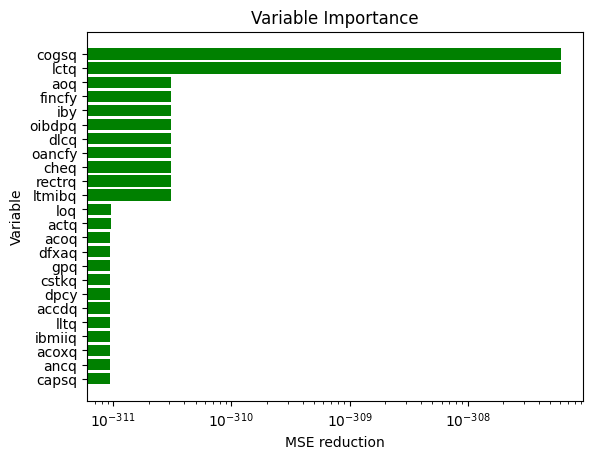

In [146]:
VarImpMean = VarImpResults.mean(axis=0)
VarImpMeanSorted = VarImpMean.sort_values(ascending=False)
VarImpMeanBest = VarImpMeanSorted[1:25]
#VarImpMeanScaled = VarImpMeanBest - VarImpMeanBest.mean()




import matplotlib.pyplot as plt
#plt.bar(VarImpMeanBest.index, VarImpMeanBest, log=True, color ='maroon', width = 0.4)#, width, bottom=VarImpMean.min(), align)
plt.barh(VarImpMeanBest.index, VarImpMeanBest, log=True, color ='green')#, height = 0.4)#, width, bottom=VarImpMean.min(), align)
plt.gca().invert_yaxis()  # labels read top-to-bottom


plt.title('Variable Importance')
plt.ylabel('Variable')
plt.xlabel('MSE reduction')
#plt.legend(['train', 'test'], loc='upper left')


plt.savefig('Results/VariableImportance3.png')
#from matplotlib.ticker import ScalarFormatter
#plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.show()




Epoch 1/5
1251/1251 - 5s - loss: 2131.0549 - mean_absolute_error: 21.1084 - val_loss: 5080.8057 - val_mean_absolute_error: 28.5144 - 5s/epoch - 4ms/step
Epoch 2/5
1251/1251 - 3s - loss: 2130.6709 - mean_absolute_error: 21.0806 - val_loss: 5099.6899 - val_mean_absolute_error: 28.7149 - 3s/epoch - 3ms/step
Epoch 3/5
1251/1251 - 3s - loss: 2129.7942 - mean_absolute_error: 21.0823 - val_loss: 5122.2764 - val_mean_absolute_error: 28.9651 - 3s/epoch - 2ms/step
Epoch 4/5
1251/1251 - 3s - loss: 2130.7034 - mean_absolute_error: 21.0791 - val_loss: 5142.3042 - val_mean_absolute_error: 29.1783 - 3s/epoch - 2ms/step
Epoch 5/5
1251/1251 - 3s - loss: 2129.3684 - mean_absolute_error: 21.0838 - val_loss: 5163.3257 - val_mean_absolute_error: 29.4103 - 3s/epoch - 3ms/step


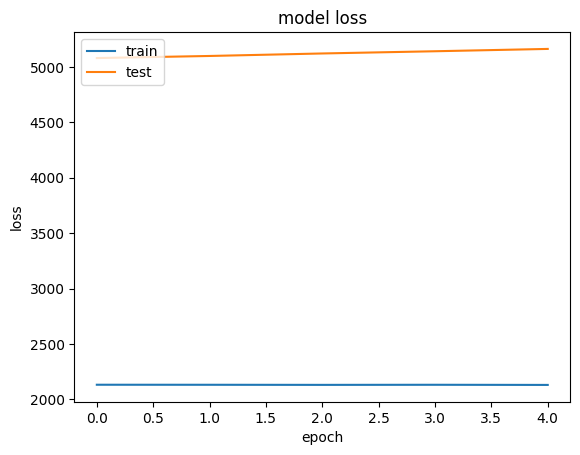

In [136]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


bestModel = keras.models.load_model('Results/BestKerasModel3')
#plot(model)


bestModel.reset_states()


compiledBestModel = bestModel.compile(optimizer="RMSprop",  # Adam(learning_rate=0.0001) #RMSprop #sgd
                                      loss="MeanSquaredError",  # 'tf.keras.losses.MeanSquaredError()',
                                      metrics=['MeanAbsoluteError'])

bestModel.reset_states()



xTrainValiPooled = scaled_X[:validationSize,:]
yTrainValiPooled = Y[:validationSize]
history = bestModel.fit(x=xTrainValiPooled, y=yTrainValiPooled, batch_size=32, epochs=5, verbose=2, validation_data = (xWinTest, yTest))


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()




In [140]:
#Visualize network

bestModel = keras.models.load_model('Results/BestKerasModel3')


import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

import pydot
import pydotplus
import graphviz

from ann_visualizer.visualize import ann_viz

ann_viz(bestModel, view=True, filename="Results/BestModel3", title="Best Model Visualized")




In [ ]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

bestModel = keras.models.load_model('Results/BestKerasModel3')




#Print summary
modelSummary = bestModel.summary()
print(modelSummary)


with open('Results/BestModelSummary3.html', 'w') as f:

    bestModel.summary(print_fn=lambda x: f.write(x + '\n'))




# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

# import pydot
# import pydotplus
# import graphviz

# tf.keras.utils.plot_model(
#     bestModel,
#     to_file="Results/BestModel.png",
#     show_shapes=True,
#     show_dtype=False,
#     show_layer_names=True,
#     rankdir="LR",
#     expand_nested=False,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=True,
# )



#pred = model.predict(xWinVal, batch_size=128)

#plt.scatter(pred, yVal)
#pred

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_69 (Dense)            (None, 5)                 430       
                                                                 
 dense_70 (Dense)            (None, 5)                 30        
                                                                 
 dropout_32 (Dropout)        (None, 5)                 0         
                                                                 
 dense_71 (Dense)            (None, 5)                 30        
                                                                 
 dropout_33 (Dropout)        (None, 5)                 0         
                                                                 
 dense_72 (Dense)            (None, 5)                 30        
                                                                 
 dropout_34 (Dropout)        (None, 5)               

In [ ]:
#ynew = model.predict_classes(Xnew)

In [ ]:
#(Geron 2019, 76, 320)

#from sklearn import RandomizedSearchCV, GridSearchCV



#(Geron 2019, 76)
from sklearn.model_selection import GridSearchCV
param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error',
return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)



grid_search.best_params_

grid_search.best_estimator_

cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)





#(Geron 2019, 320)


def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
        model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model


keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


keras_reg.fit(X_train, y_train, epochs=100,
validation_data=(X_valid, y_valid),
callbacks=[keras.callbacks.EarlyStopping(patience=10)])
mse_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_new)




from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=100,
validation_data=(X_valid, y_valid),
callbacks=[keras.callbacks.EarlyStopping(patience=10)])


rnd_search_cv.best_params_
rnd_search_cv.best_score_
model = rnd_search_cv.best_estimator_.model








#Chollet: DL for Python
import kerastuner as kt





#strategy = tf.distribute.MirroredStrategy()





#If your search process crashes, you can always restart it—just specify overwrite=False in the tuner so that it can resume from the trial logs stored on disk.




